# Materia: Tópicos selectos de grandes bases de datos I
# Profesor: CESAR LOZANO DIAZ
### Alumno : Ortega Camargo Fernando
### Github Tarea: https://github.com/Fortega95/topicosMCD/blob/main/Codigos/Tarea3_TopicosFernandoOrtega.ipynb

# <font color="#008080">k-means</font>

**Objetivo de la Tarea**  Implementar manualmente el algoritmo de K-means en un conjunto de datos específico utilizado en clase (culquiera de los 3 ejemplos), con la finalidad de comprender cómo funciona el algoritmo sin el uso de las bibliotecas, cómo se actualizan los centroides en cada iteración, y cómo se asignan los puntos a los clusters más cercanos.


<font color="red">**Identifica el conjunto de datos utilizado en clase para el ejemplo de K-means. Si no tienes acceso directo a él, selecciona un conjunto de datos simple con características similares (por ejemplo, datos bidimensionales para facilitar la visualización).**</font>


Para esta tarea utilizaremos el dataset visto en clase de WholeShale, el cual tiene informacion de ventas por mayoreo en diferentes regiones y canales de venta

In [1]:
#Cargamo nuestras librerias necesarias
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc

In [2]:
# Cargamos nuestra data
data = pd.read_csv("C://Users//ortca//MCD//TopicosBases//bases//Wholesale.csv")

<font color="red">**Asegúrate de que el conjunto de datos esté limpio y listo para usar. Esto incluye eliminar valores faltantes o tratarlos adecuadamente, y normalizar los datos si es necesario.**</font>

Com oen este caso queremos clusterizar mediante las variables numericas eliminamos las categorias region y canal

In [3]:
data_new= data.drop(columns=["Channel","Region"])

In [4]:
### veamos si hay nulos

data_new.isna().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
data_new.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [6]:
### Nos encontramos con un dataset de alta varianza por lo que normalizaremos las variables

data_scaled = normalize(data_new)
data_scaled= pd.DataFrame(data_scaled)

In [7]:
data_scaled.head(3)

,0,1,2,3,4,5
0,0.708333,0.539874,0.422741,0.011965,0.149505,0.074809
1,0.442198,0.614704,0.599540,0.110409,0.206342,0.111286
2,0.396552,0.549792,0.479632,0.150119,0.219467,0.489619


En nuestro dataset tenemos 6 dimensiones numéricas por lo que reduciremos su dimensionalidad con PCA a dos para hacer mas evidente la agrupación

In [8]:
#Iniciamos el objeto tipo PCA
pca= PCA()

In [9]:
# Calculamos las componentes para nuestros datos escalados
data_scaled_pca = pca.fit_transform(data_scaled)

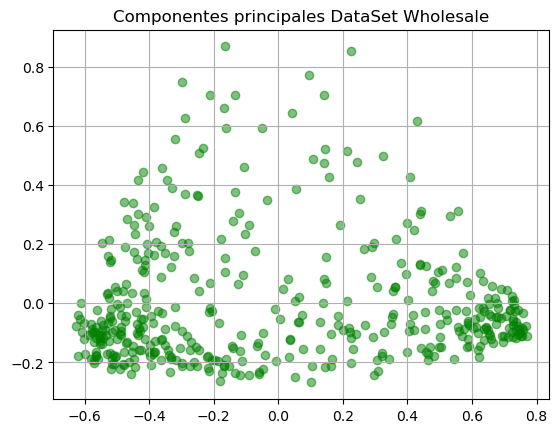

In [11]:
#Visualizamos la data
plt.scatter(data_scaled_pca[:, 0], data_scaled_pca[:, 1], color='green', alpha=0.5)
plt.grid()
plt.title(f'Componentes principales DataSet Wholesale')
plt.show()

Analizando el grafico de las componentes principales podemos visuaalizar cumulos claros de información por lo que nos da un buen indicio de que servirán para nuestra agrupación, adicional validemos la varianza explicada por las componentes para estar seguros que resumira bien nuestro dataset

In [12]:
np.cumsum((pca.fit(data_scaled).explained_variance_ratio_))/np.sum(pca.fit(data_scaled).explained_variance_ratio_)

array([0.68188493, 0.82803656, 0.92425874, 0.95753051, 0.97947363,
       1.        ])

Como podemos ver resumimos un 82% de la data original lo que es una buena transformación

Almacenamos nuestras componentes en un DF

In [13]:
componentes = data_scaled_pca[:,:2]

In [14]:
data_pcca = pd.DataFrame(data_scaled_pca[:,:2])

<font color="red">**Selecciona el número de clusters K que se utilizó en el ejemplo de clase. Si no recuerdas el número exacto, elige un K basado en tu conocimiento del conjunto de datos o utilizando el método del codo para determinar un buen valor.**</font>

Utilizaremos inicialmente el Cluster jerarquico para visualizar el dendograma de las componentes y asi tener una idea de las particiones con mayor distancia. Consideraremos la distancia ward la cual minimiza la varianza total dentro de los clusters cuando se fusionan. Se calcula tomando en cuenta la suma de cuadrados de las diferencias entre cada punto y el centroide de su cluster, antes y después de la fusión de dos clusters.

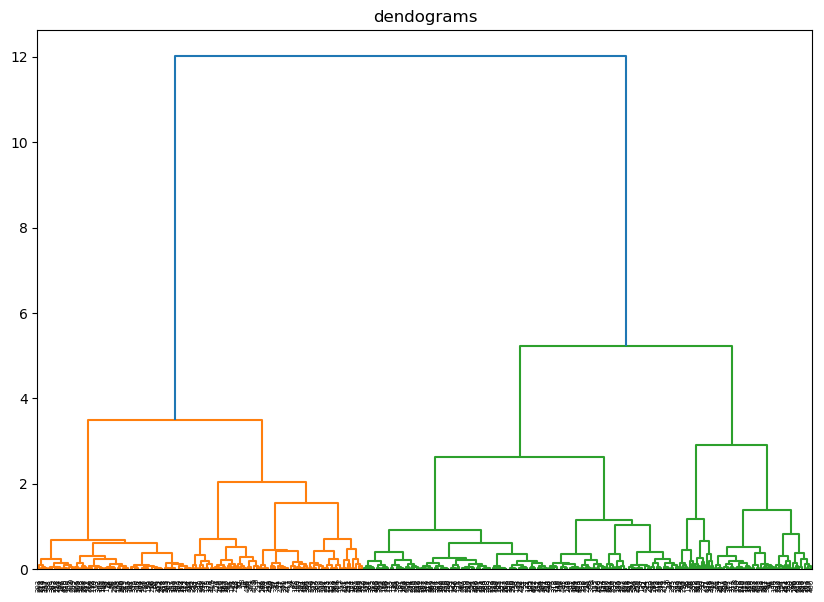

In [15]:
plt.figure(figsize=(10,7))

plt.title("dendograms")

dend = shc.dendrogram(shc.linkage(data_pcca,method="ward"))

Revisando el dendograma anterior podemos encontrar que el salto más grandes en grupos estan para 2 , por lo que probaremos con este.

# <font color="#008080">Calculo manueal K-means</font>

<font color="red">**Inicializa los centroides de los clusters. Puedes hacerlo seleccionando aleatoriamente K puntos del conjunto de datos como los centroides iniciales o utilizando cualquier otro método mencionado en clase.**</font>

In [16]:
# Como vimos anteriormente definimos en 2 nuestro número de clusters
k = 2

# Inicializamos nuestros centroides como valores aleatorios dentro de nuestros elementos, es decir , estamos tomando elementos
#Como centroides

centroids = componentes[np.random.choice(len(componentes), k, replace=False)]

# Definimos el número de iteraciones para el ciclo de kmeans, por si el algoritmo no llega a converger, lo limitamos con
#esto
max_iters = 10

In [17]:
centroids   #validamos los centroides finales

array([[-0.27901725,  0.20451235],
       [ 0.54531417, -0.1876469 ]])

* <font color="red">**Para cada punto en el conjunto de datos, calcula la distancia entre ese punto y cada uno de los centroides.
Asigna cada punto al cluster cuyo centroide sea el más cercano. Puedes usar la distancia euclidiana para calcular la cercanía.**</font>
* <font color="red">**Una vez que todos los puntos han sido asignados a un cluster, recalcula el centroide de cada cluster. El nuevo centroide es el promedio de todos los puntos que han sido asignados a ese cluster.**</font>
* <font color="red">**Repite los pasos 3 y 4 hasta que los centroides ya no cambien significativamente entre iteraciones, lo que indica que el algoritmo ha convergido, o hasta alcanzar un número máximo de iteraciones definido previamente.**</font>


In [18]:
# Iteraremos dentro del maximo de iteraciones o cuando los centroides ya no cambien dentro de las mismas
# para ello definimos una variable que guarde los centroides anteriore y los nuevos con lo que con eso controlaremos los ciclos


for iteration in range(max_iters):
    
    # Paso 1: Asignamos nuestra data al cluster más cercano mediate una matriz de distancias que en este caso definimos 
    #con la norma 2
    distances = np.linalg.norm(componentes[:, np.newaxis] - centroids, axis=2,ord=2)
    
    ###
    labels = np.argmin(distances, axis=1)

    # Paso 2: Calculamos los nuevos centroides como el promedio de los puntos en cada cluster
    new_centroids = np.array([componentes[labels == j].mean(axis=0) for j in range(k)])
    
    # Paso 3: Validamos la convergencia con las iteraciones o cambios nulos en centroides
    if np.all(centroids == new_centroids):
        break

    centroids = new_centroids
    


In [19]:
# Resultados finales
print("\nResultados finales:")
print("Etiquetas:", labels)
print("Centroides finales:")
print(centroids)


Resultados finales:
Etiquetas: [0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0
 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0
 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1
 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1]
Centroides finales:
[[-0.35261393 -0.00124322]
 [ 0.48603542  0.00171363]]


* <font color="red">**Evalúa el resultado del clustering. Puedes hacerlo visualmente si el conjunto de datos es bidimensional, o utilizando métricas como la Suma de Cuadrados Dentro de los Clusters (WCSS) para conjuntos de datos de mayor dimensionalidad.**</font>


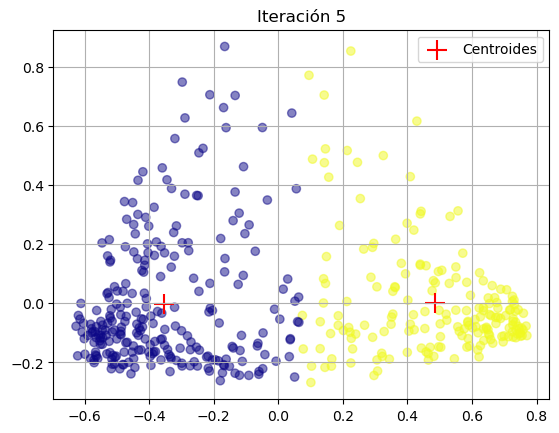

In [20]:
#Visualizamos la data para ver los clusters generados

plt.scatter(componentes[:, 0], componentes[:, 1], c=labels, cmap='plasma', alpha=0.5)
plt.grid()
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='+', s=200, label='Centroides')
plt.title(f'Iteración {iteration + 1}')
plt.legend()
plt.show()

Los cumulos vistos en los componentes iniciales parecen ser puntos de acumulación o categorias bien definidas por lo que el algoritmo parece haber calibrado bien los centroides.

Como métrica de evaluación del cluster óptimo usaremos la inercia, primeramente la calculamos para nuestro cluster k=2

In [21]:
inertia = 0
for i in range(len(componentes)):
    # asignamos por cada dato la cateogira predicha de su cluster
    cluster_index = labels[i]
    
    # Calculamos la distancia euclidiana al cuadrado de cada dato con su cluster predicho
    distance_squared = np.sum((componentes[i] - centroids[cluster_index]) ** 2)
    
    # Sumamos la inercia total
    inertia += distance_squared
    
print(f"La inercia para k=2 es : {inertia}")

La inercia para k=2 es : 35.26834508742915


Teniendo en cuenta lo anterior, hagamos el mismo proceso para k = 1 hasta 7 para validar el comportamiento de la inercia

In [22]:
#### validemos para varios clusters

# Número de clusters
k = [1,2,3,4,5,6,7]
inercias_full=[]
for i in k:
    centroids = componentes[np.random.choice(len(componentes), i, replace=False)]
    max_iters = 10
    media_distancias=[]
    for iteration in range(max_iters):
        distances = np.linalg.norm(componentes[:, np.newaxis] - centroids, axis=2,ord=2)
        labels = np.argmin(distances, axis=1)


        new_centroids = np.array([componentes[labels == j].mean(axis=0) for j in range(i)])
        media_distancias.append(new_centroids)

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    inertia = 0
    for i in range(len(componentes)):
        cluster_index = labels[i]

        distance_squared = np.sum((componentes[i] - centroids[cluster_index]) ** 2)

        inertia += distance_squared
        
    inercias_full.append(inertia)


Grafiquemos nuestras inercia para mediante el criterio del codo dictaminar si nuestra elección inicial fue correcta.

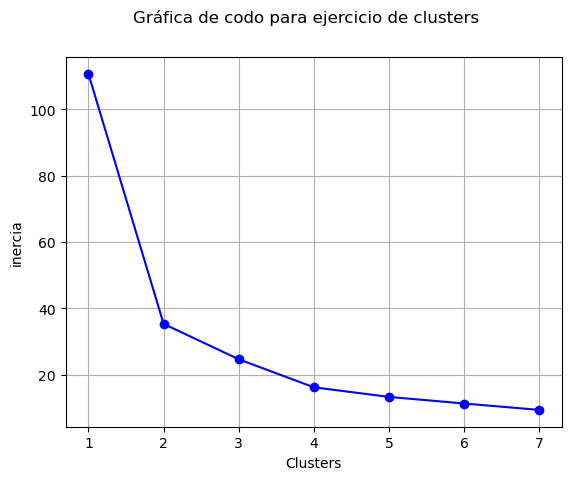

In [23]:
plt.plot(k,inercias_full,"b-o")
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("inercia")

plt.suptitle("Gráfica de codo para ejercicio de clusters")

plt.show()

Bajo este ejercicio validamos que nuestro número 2 sería el óptimo, pues vemos que para clusters mayores a 2, el impacto en términos de incercia es mínimo.

* <font color="red">**Reflexiona sobre el proceso y los resultados. ¿El número de clusters K elegido inicialmente fue adecuado? ¿Cómo afectó la inicialización de los centroides al resultado final? ¿Hubo algún desafío en particular durante la implementación?**</font>


El ejercicio en general ayudo batante a la compresión del algoritmo de K means, pues su implementación manual ayudó a corroborar aspectos técnicos que muchas veces pasan desapercibidos cuando solo ejecutamos un algoritmo predefinido. En nuestro caso particular la reducción de dimensionalidad, y la normalización ayudaron a resumir información de 6 componentes en 2, aproximando el 82% de su varianza, por lo que esto también influenció en que el algoritmo de kmeans tuviera un mejor desempeño.  
Inicialmente se consideró el método de cluster jerarquico para la elaboración de un dendograma que nos permitiera tener los primeros indicios del comportamiento de los componentes principales utilizados, comportamiento que evidenció una clara partición en 2, o 3 grupos óptima. Dado esto y por simplicidad se eligió k = 2 para inicializar el modelo, con lo que se calibró el algorimo manual esperando dos grupos. Teniendo esto en cuenta dentro del modelo hubo dos puntos a considerar, primero, se usó la distancia euclidiana o norma 2 para medir las distancias, esto puede influenciar mucho en la forma de llegar a los centroides óptimos y se debe calibrar segun nuestro problema, en nuestro caso , al tener variables númericas, la norma dos fue útil para la calibración de los clusters.  
Otro punto a considerar es la selección de los centroides iniciales, los cuales normalmente no son los datos, si no que son puntos aleatorios en el espacio de resultados, esta elección puede modificar drasticamente la covergencia de nuestro modelo, pues al estar dentro de la data, podríamos caer en mínimos locales haciendo una convergencia erronea.Para solucionar esto y dentro de una práctica más robusta es que la convención será inicializar en valores aleatorios del espacio y no en los datos.  
Como dato importante K means es un algoritmo robusto pero computacionalmente costoso pues tiene que calibrar dato por dato distancias e iterar haciendo lo mismo hasta la covnergencia, esto hace que su estudio sea halgo complejo pues para calibrar el número de cluster optímo con un método como el codo, se tiene que realizar lo anterior mencionado, el numero de veces que queramos validar grupos diferentes por lo que la complejidad computacional sigue aumentado, motivo de esto es que se considera mejor alternativa el uso de los dendogramas los cuales nos arrojan un primer parametro rápido para iniciar con als calibraciones.Esto es importante pues si estamos en un problema dentro de bigdata, la calibración de multiples matrices de distancias podría ser muy tardado.  
En resumen, el algoritmo K-means es una técnica eficiente y simple para agrupar datos en clusters, pero su rendimiento depende de decisiones críticas como la elección del número de clusters (k) y la métrica de distancia. La inicialización de centroides y la sensibilidad a la elección de k son aspectos importantes a considerar pues de ello dependera la correcta convergencia del modelo. 